In [1]:
import gym
import random
import numpy as np
import pandas as pd
from datetime import timedelta
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
id = 903657078

In [2]:
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(id)
sixteen = generate_random_map(16)
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],

    "16x16": sixteen
}

In [3]:
def value_iteration(env, discount=0.9, epsilon=1e-12):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    policy = np.zeros((1, number_of_states))
    value_list = np.zeros((1, number_of_states))
    old_value_list = value_list.copy()
    episode = 0
    max_change = 1
    sigma = discount
    while max_change > epsilon:
        episode += 1
        for s in range(number_of_states):
            assigned_value = -np.inf
            for a in range(number_of_actions):
                # get new state and its reward        
                total_cand_value = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    # get new state value
                    value_new_state = old_value_list[0][new_state]
                    cand_value = 0
                    if done:
                        cand_value = reward 
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_cand_value += cand_value*prob 
                        
                if total_cand_value > assigned_value:
                    assigned_value = total_cand_value
                    policy[0][s] = a
                    value_list[0][s] = assigned_value
        changes = np.abs(value_list - old_value_list)
        max_change = np.max(changes)
        old_value_list = value_list.copy()
        
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(episode, time_spent))
    return policy[0], episode, time_spent

In [4]:
def policy_iteration(env, discount=0.9, epsilon=1e-3):
    
    start = timer()
    
    number_of_states = env.observation_space.n
    number_of_actions = env.action_space.n
    ## 1
    policy = np.random.randint(number_of_actions, size=(1,number_of_states))
    value_list = np.zeros((1, number_of_states))
    episode = 0
    sigma = discount
    
    ## 2
    policy_stable = False
    while not policy_stable:
        episode += 1
        eval_acc = True
        while eval_acc:
            eps = 0
            for s in range(number_of_states):
                # first row
                v = value_list[0][s]

                # get the new value 
                a = policy[0][s]
                total_val_new_state = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    value_new_state = value_list[0][new_state]
                    # second row
                    cand_value = 0
                    if done:
                        cand_value = reward                     
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_val_new_state += cand_value*prob 
                value_list[0][s] = total_val_new_state
                    
                # third row
                eps = max(eps, np.abs(v-value_list[0][s]))
            if eps < epsilon:
                eval_acc = False


        ## 3
        policy_stable = True
        for s in range(number_of_states):

            # assign 
            old_action = policy[0][s]
            # get the argmax a here
            max_value = -np.inf
            for a in range(number_of_actions):
                # get the new value 
                total_cand_value = 0
                for prob, new_state, reward, done in env.P[s][a]:
                    value_new_state = value_list[0][new_state]
                    cand_value = 0
                    if done:
                        cand_value = reward
                    else:
                        cand_value = reward + sigma*value_new_state
                    total_cand_value += prob*cand_value
                if total_cand_value > max_value:
                    max_value = total_cand_value
                    policy[0][s] = a

            # if old-action != policy[s]
            if old_action != policy[0][s]:
                policy_stable = False
    
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("Solved in: {} episodes and {} seconds".format(episode, time_spent))
    return policy[0], episode, time_spent

In [5]:
def test_policy(env, policy, n_epoch=1000):
    rewards = []
    episode_counts = []
    for i in range(n_epoch):
        current_state = env.reset()
        ep = 0
        done = False
        episode_reward = 0
        while not done and ep < 1000:
            ep += 1
            act = int(policy[current_state])
            new_state, reward, done, _ = env.step(act)
            episode_reward += reward
            current_state = new_state
            
        rewards.append(episode_reward)
        episode_counts.append(ep)
    
    # finish
    mean_reward = sum(rewards)/len(rewards)
    mean_eps = sum(episode_counts)/len(episode_counts)
    return mean_reward, mean_eps, rewards, episode_counts 

In [6]:
def train_and_test_pi_vi(env, discount=[0.9], epsilon=[1e-9], mute=False):
    
    vi_dict = {}
    
    for dis in discount:
        vi_dict[dis] = {}
        for eps in epsilon:
            vi_dict[dis][eps] = {}
            
            # value iteration
            vi_policy, vi_solve_iter, vi_solve_time = value_iteration(env, dis, eps)
            vi_mrews, vi_meps, _, __ = test_policy(env, vi_policy)    
            vi_dict[dis][eps]["mean_reward"] = vi_mrews
            vi_dict[dis][eps]["mean_eps"] = vi_meps
            vi_dict[dis][eps]["iteration"] = vi_solve_iter
            vi_dict[dis][eps]["time_spent"] = vi_solve_time
            vi_dict[dis][eps]["policy"] = vi_policy
            if not mute:
                print("Value iteration for {} discount and {} eps is done".format(dis, eps))
                print("Iteration: {} time: {}".format(vi_solve_iter, vi_solve_time))
                print("Mean reward: {} - mean eps: {}".format(vi_mrews, vi_meps))
    
    # policy iteration
    pi_dict = {}
    for dis in discount:
        pi_dict[dis] = {}
        for eps in epsilon:
            pi_dict[dis][eps] = {}

            pi_policy, pi_solve_iter, pi_solve_time = policy_iteration(env, dis, eps)
            pi_mrews, pi_meps, _, __ = test_policy(env, pi_policy)    
            pi_dict[dis][eps]["mean_reward"] = pi_mrews
            pi_dict[dis][eps]["mean_eps"] = pi_meps
            pi_dict[dis][eps]["iteration"] = pi_solve_iter
            pi_dict[dis][eps]["time_spent"] = pi_solve_time
            pi_dict[dis][eps]["policy"] = pi_policy
            if not mute:
                print("Policy iteration for {} discount is done".format(dis))
                print("Iteration: {} time: {}".format(pi_solve_iter, pi_solve_time))
                print("Mean reward: {} - mean eps: {}".format(pi_mrews, pi_meps))

    
    return vi_dict, pi_dict

In [7]:
def map_discretize(the_map):
    size = len(the_map)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(the_map):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def see_policy(map_size, policy):
    map_name = str(map_size)+"x"+str(map_size)
    data = map_discretize(MAPS[map_name])
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest", cmap='gray')

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="r")
    plt.show()

In [8]:
def plot_the_dict(dictionary, value="Score", size=4, variable="Discount Rate", log=False):

    plt.figure(figsize=(10, 6))
    title = "Average {} on {}x{} Frozen Lake".format(value, size, size)
    the_val = value
    value = "Average {}".format(the_val)
    val_type = "Type of {}".format(the_val)
    the_df = pd.DataFrame(columns=[variable, value, val_type])
    for k, v in dictionary.items():
        for val in v:
            if not log:
                dic = {variable: k, value: float(val), val_type: "Average +- std"}
            else:
                dic = {variable: np.log10(k), value: float(val), val_type: "Average +- std"}                
            the_df = the_df.append(dic, ignore_index=True)
        if not log:
            dic = {variable: k, value: float(max(v)), val_type: "Max"}
        else:
            dic = {variable: np.log10(k), value: float(max(v)), val_type: "Max"}
        the_df = the_df.append(dic, ignore_index=True)
    sns.lineplot(x=variable, y=value, hue=val_type, style=val_type, markers=True, data=the_df).set(title=title)

In [9]:
def convert_dict_to_dict(the_dict):
    
    # return for discount
    discount_rewards = {}
    discount_iterations = {}
    discount_times = {}


    for disc in the_dict:
        discount_rewards[disc] = []    
        discount_iterations[disc] = []    
        discount_times[disc] = []

        for eps in the_dict[disc]:
            discount_rewards[disc].append(the_dict[disc][eps]['mean_reward'])
            discount_iterations[disc].append(the_dict[disc][eps]['iteration'])        
            discount_times[disc].append(the_dict[disc][eps]['time_spent'].total_seconds())  

            
    epsilon_rewards = {}
    epsilon_iterations = {}
    epsilon_times = {}
    for eps in the_dict[0.5]:
        epsilon_rewards[eps] = []    
        epsilon_iterations[eps] = []    
        epsilon_times[eps] = []
    
        for disc in vi_dict:
            epsilon_rewards[eps].append(the_dict[disc][eps]['mean_reward'])
            epsilon_iterations[eps].append(the_dict[disc][eps]['iteration'])        
            epsilon_times[eps].append(the_dict[disc][eps]['time_spent'].total_seconds()) 
            
    return discount_rewards, discount_iterations, discount_times, epsilon_rewards, epsilon_iterations, epsilon_times

In [10]:
env = gym.make("FrozenLake-v1")
vi_dict, pi_dict = train_and_test_pi_vi(env, discount=[0.5, 0.7, 0.9, 0.99, 0.999], 
                                        epsilon=[1e-2, 1e-4, 1e-6, 1e-8, 1e-10], mute=True)

Solved in: 4 episodes and 0:00:00.000672 seconds
Solved in: 10 episodes and 0:00:00.001646 seconds
Solved in: 16 episodes and 0:00:00.002664 seconds
Solved in: 22 episodes and 0:00:00.003556 seconds
Solved in: 28 episodes and 0:00:00.004576 seconds
Solved in: 6 episodes and 0:00:00.001015 seconds
Solved in: 16 episodes and 0:00:00.002730 seconds
Solved in: 27 episodes and 0:00:00.004858 seconds
Solved in: 39 episodes and 0:00:00.006644 seconds
Solved in: 50 episodes and 0:00:00.008438 seconds
Solved in: 10 episodes and 0:00:00.001630 seconds
Solved in: 44 episodes and 0:00:00.007634 seconds
Solved in: 78 episodes and 0:00:00.013115 seconds
Solved in: 112 episodes and 0:00:00.019219 seconds
Solved in: 145 episodes and 0:00:00.026297 seconds
Solved in: 30 episodes and 0:00:00.005026 seconds
Solved in: 172 episodes and 0:00:00.030175 seconds
Solved in: 305 episodes and 0:00:00.052361 seconds
Solved in: 438 episodes and 0:00:00.076032 seconds
Solved in: 571 episodes and 0:00:00.098330 seco

In [11]:
vi_dict[0.99]

{0.01: {'mean_reward': 0.736,
  'mean_eps': 42.342,
  'iteration': 30,
  'time_spent': datetime.timedelta(microseconds=5026),
  'policy': array([0., 3., 0., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 0.0001: {'mean_reward': 0.723,
  'mean_eps': 43.489,
  'iteration': 172,
  'time_spent': datetime.timedelta(microseconds=30175),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-06: {'mean_reward': 0.727,
  'mean_eps': 44.498,
  'iteration': 305,
  'time_spent': datetime.timedelta(microseconds=52361),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-08: {'mean_reward': 0.754,
  'mean_eps': 43.619,
  'iteration': 438,
  'time_spent': datetime.timedelta(microseconds=76032),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-10: {'mean_reward': 0.745,
  'mean_eps': 43.379,
  'iteration': 571,
  'time_spent': datetime.timedelta(microseconds=98330),
  'policy': a

In [12]:
pi_dict[0.999]

{0.01: {'mean_reward': 0.762,
  'mean_eps': 44.075,
  'iteration': 5,
  'time_spent': datetime.timedelta(microseconds=5504),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 0.0001: {'mean_reward': 0.738,
  'mean_eps': 45.993,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=22808),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-06: {'mean_reward': 0.759,
  'mean_eps': 44.353,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=49788),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-08: {'mean_reward': 0.728,
  'mean_eps': 45.962,
  'iteration': 7,
  'time_spent': datetime.timedelta(microseconds=96705),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-10: {'mean_reward': 0.745,
  'mean_eps': 46.337,
  'iteration': 4,
  'time_spent': datetime.timedelta(microseconds=79339),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])}}

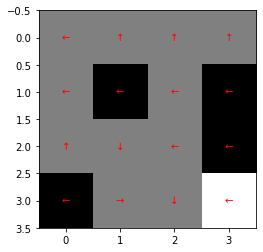

In [13]:
pol = vi_dict[0.99][1e-8]['policy']
vi4 = convert_dict_to_dict(vi_dict)
see_policy(4, pol)

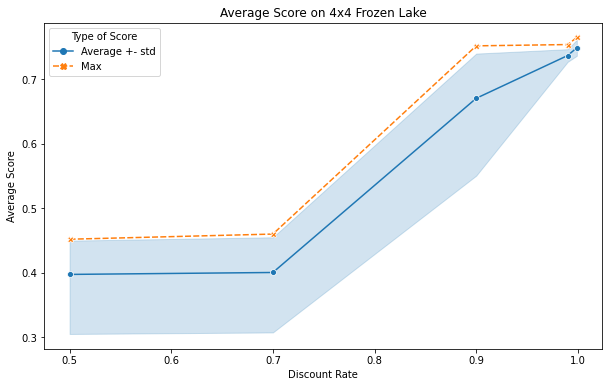

In [14]:
plot_the_dict(vi4[0], value="Score", size=4)

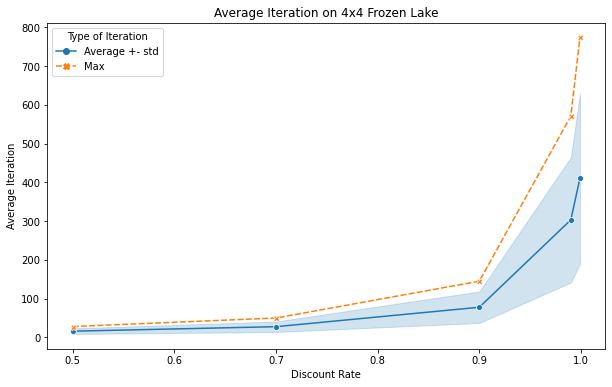

In [15]:
plot_the_dict(vi4[1], value="Iteration", size=4)

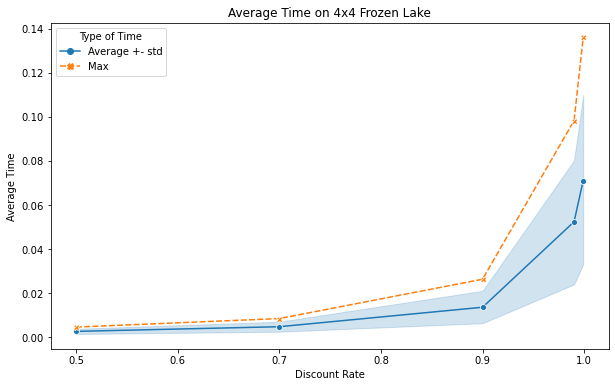

In [16]:
plot_the_dict(vi4[2], value="Time", size=4)

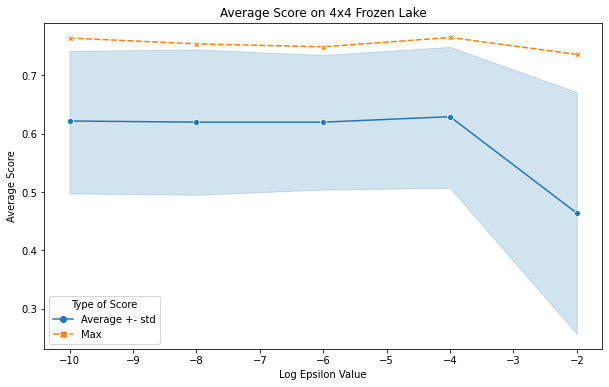

In [17]:
plot_the_dict(vi4[3], value="Score", size=4, variable="Log Epsilon Value", log=True)

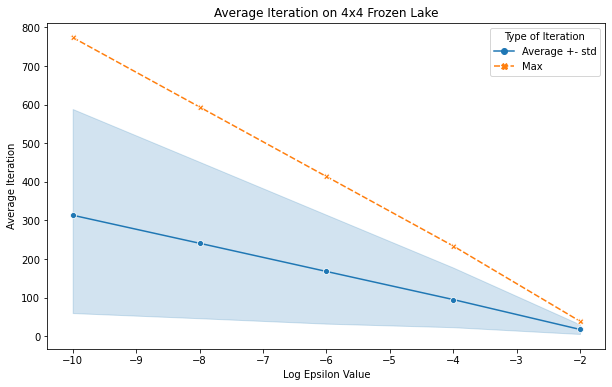

In [18]:
plot_the_dict(vi4[4], value="Iteration", size=4, variable="Log Epsilon Value", log=True)

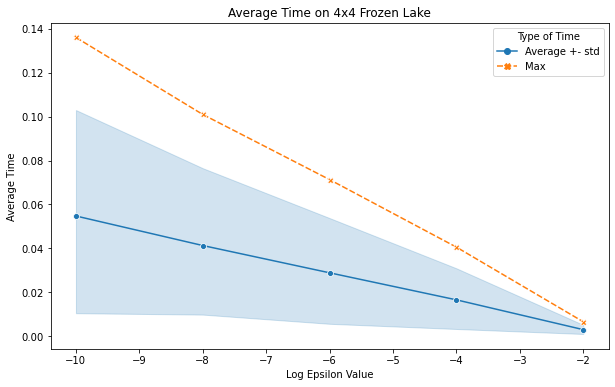

In [19]:
plot_the_dict(vi4[5], value="Time", size=4, variable="Log Epsilon Value", log=True)

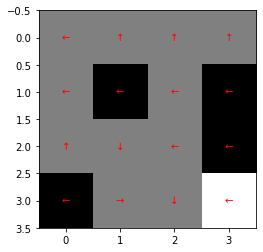

In [20]:
pol = pi_dict[0.99][1e-8]['policy']
pi4 = convert_dict_to_dict(pi_dict)
see_policy(4, pol)

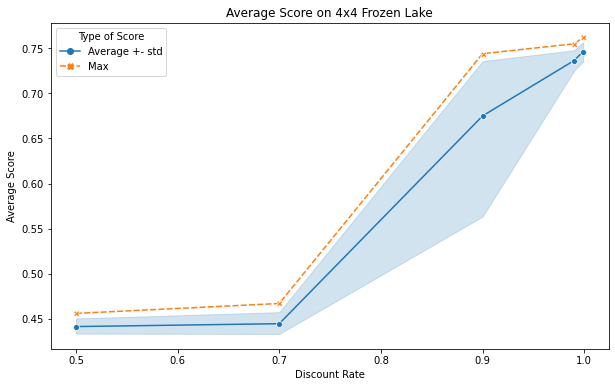

In [21]:
plot_the_dict(pi4[0], value="Score", size=4)

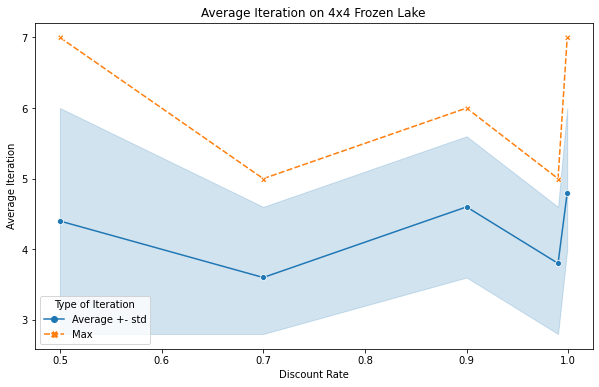

In [22]:
plot_the_dict(pi4[1], value="Iteration", size=4)

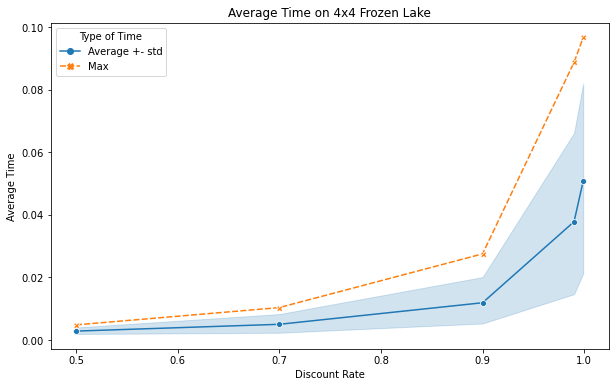

In [23]:
plot_the_dict(pi4[2], value="Time", size=4)

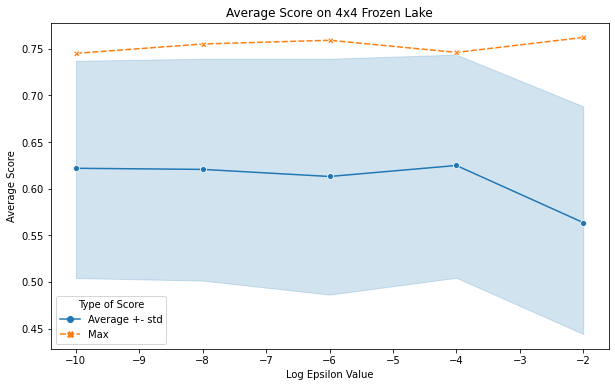

In [24]:
plot_the_dict(pi4[3], value="Score", size=4, variable="Log Epsilon Value", log=True)

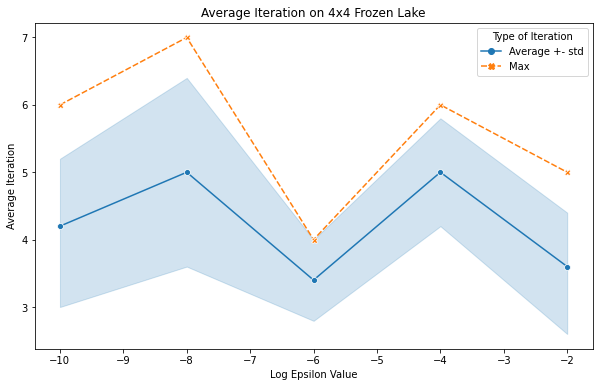

In [25]:
plot_the_dict(pi4[4], value="Iteration", size=4, variable="Log Epsilon Value", log=True)

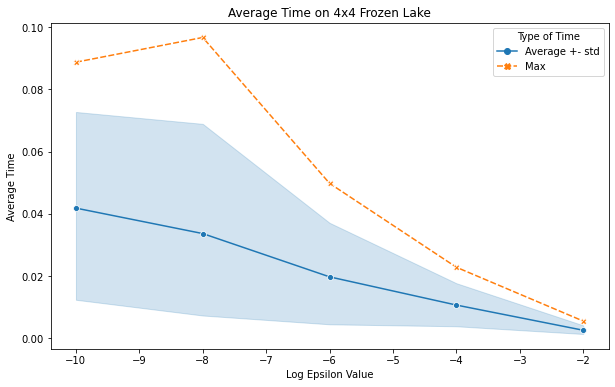

In [26]:
plot_the_dict(pi4[5], value="Time", size=4, variable="Log Epsilon Value", log=True)

## 16 * 16

In [27]:
env = FrozenLakeEnv(desc=MAPS["16x16"])
vi_dict16, pi_dict16 = train_and_test_pi_vi(env, discount=[0.5, 0.7, 0.9, 0.99, 0.999], 
                                          epsilon=[1e-2, 1e-4, 1e-6, 1e-8, 1e-10], mute=True)

Solved in: 4 episodes and 0:00:00.008180 seconds
Solved in: 10 episodes and 0:00:00.019723 seconds
Solved in: 16 episodes and 0:00:00.032538 seconds
Solved in: 22 episodes and 0:00:00.044629 seconds
Solved in: 28 episodes and 0:00:00.058191 seconds
Solved in: 6 episodes and 0:00:00.011585 seconds
Solved in: 16 episodes and 0:00:00.033238 seconds
Solved in: 28 episodes and 0:00:00.059286 seconds
Solved in: 40 episodes and 0:00:00.088478 seconds
Solved in: 52 episodes and 0:00:00.119939 seconds
Solved in: 10 episodes and 0:00:00.019712 seconds
Solved in: 43 episodes and 0:00:00.096724 seconds
Solved in: 81 episodes and 0:00:00.185372 seconds
Solved in: 120 episodes and 0:00:00.287728 seconds
Solved in: 158 episodes and 0:00:00.368367 seconds
Solved in: 23 episodes and 0:00:00.047862 seconds
Solved in: 248 episodes and 0:00:00.581698 seconds
Solved in: 487 episodes and 0:00:01.138921 seconds
Solved in: 726 episodes and 0:00:01.761124 seconds
Solved in: 965 episodes and 0:00:02.281566 seco

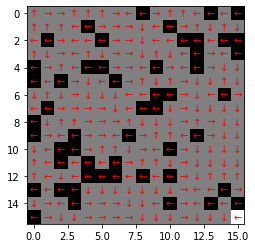

In [28]:
pol = vi_dict16[0.999][1e-10]['policy']
vi16 = convert_dict_to_dict(vi_dict16)
see_policy(16, pol)

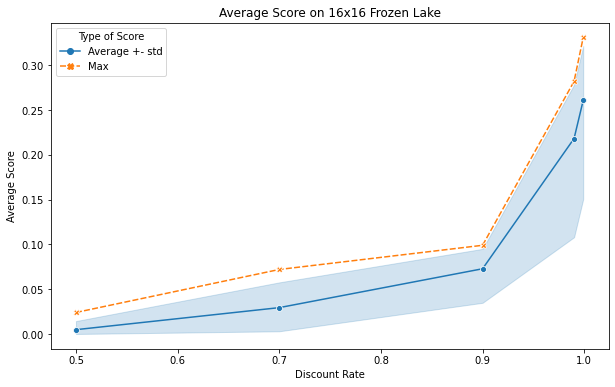

In [29]:
plot_the_dict(vi16[0], value="Score", size=16)

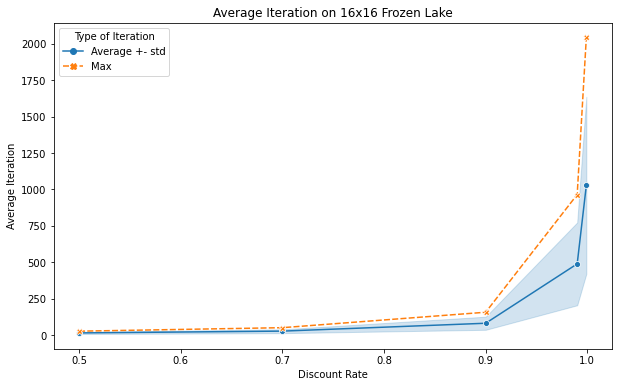

In [30]:
plot_the_dict(vi16[1], value="Iteration", size=16)

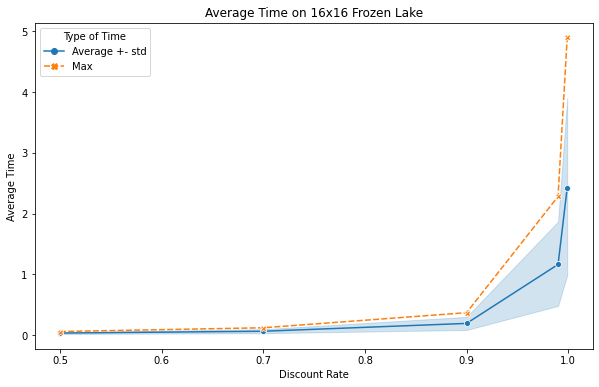

In [31]:
plot_the_dict(vi16[2], value="Time", size=16)

In [32]:
pi16 = convert_dict_to_dict(pi_dict16)

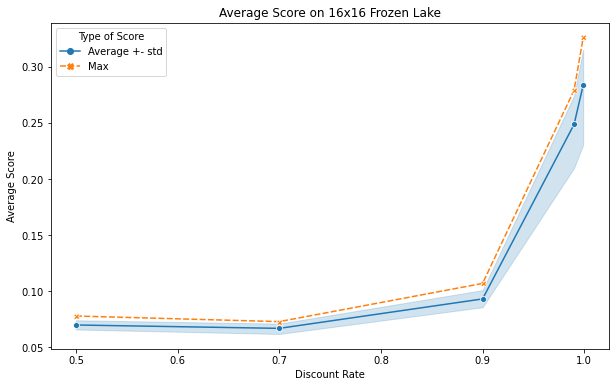

In [33]:
plot_the_dict(pi16[0], value="Score", size=16)

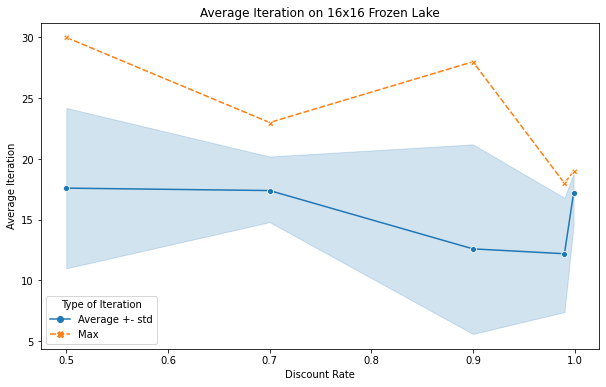

In [34]:
plot_the_dict(pi16[1], value="Iteration", size=16)

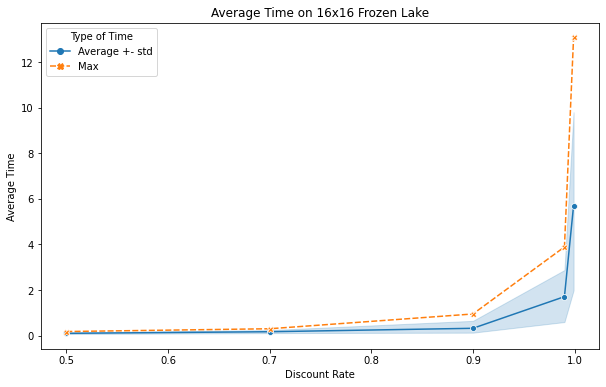

In [35]:
plot_the_dict(pi16[2], value="Time", size=16)